In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))
from utils import show_classification_report, random_over_sample, random_under_sample, smote_over_sample, tomek_under_sample, SampledDataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

# Load Dataset 

In [2]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')
dataset.drop(columns=['lon', 'lat'], inplace=True, errors='ignore')
print("=== Dataset Types :\n", dataset.dtypes)

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print("=== Null Values :\n", dataset.isnull().sum())

X_df = dataset.drop('fire', axis=1)
X_numeric_columns = X_df.select_dtypes(include=['number']).columns
X_df[X_numeric_columns] = StandardScaler().fit_transform(X_df[X_numeric_columns])
X_df = pd.get_dummies(X_df, columns=X_df.select_dtypes(include=['object']).columns)

Y_df = dataset['fire']

print("=== X columns:", X_df.columns)
print("=== Y index:", Y_df.index)

=== Dataset Types :
 fire                        int64
log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                   float64
tmax_s2                   float64
tmax_s3                   float64
tmax_s4                   float64
amplitude_thermique_s1    float64
amplitude_thermique_s2    float64
amplitude_thermique_s3    float64
amplitude_thermique_s4    float64
GRIDCODE                  float64
log_area_sqm              float64
lcc_code_encoded          float64
elevation                 float32
COARSE                    float64
SAND                      float64
SILT                      float64
CLAY                      float64
TEXTURE_USDA              float64
TEXTURE_SOTER              object
BULK                      float64
REF_BULK                  float64
ORG_CARBON                float64
PH_WATER                  float64
TOTAL_N                   float64
CN_RATIO                  f

# Scratch Model Implementation

In [4]:

import numpy as np
from collections import Counter

class FastKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distances(self, X):
        """
        Vectorized distance computation:
        Computes distances from many samples X to all training samples.
        Uses (a - b)^2 = a^2 + b^2 - 2ab trick.
        """

        # X: (n_test, n_features)
        # X_train: (n_train, n_features)

        X_square = np.sum(X**2, axis=1).reshape(-1, 1)          # (n_test, 1)
        train_square = np.sum(self.X_train**2, axis=1)          # (n_train,)
        cross = X @ self.X_train.T                               # (n_test, n_train)

        # squared distances (no sqrt needed)
        dists = X_square + train_square - 2 * cross
        return dists

    def predict(self, X):
        # Compute all distances in one shot
        dists = self._euclidean_distances(X)

        # Indices of k nearest neighbors per test sample
        k_indices = np.argpartition(dists, self.k, axis=1)[:, :self.k]

        # Convert labels
        k_labels = self.y_train[k_indices]

        # Majority vote across axis 1
        preds = np.array([Counter(row).most_common(1)[0][0] for row in k_labels])
        return preds



knn_scratch = FastKNN(k=5)
knn_scratch.fit(X_train, Y_train)

# Util Functions

In [ ]:
sampled_dataset = SampledDataset(["Original", "Random Over-Sampling", "Random Under-Sampling", "SMOTE Over-Sampling", "Tomek Links Under-Sampling"])

def main(X_df, Y_df):
    _X_np_train, _X_np_test, _Y_np_train, _Y_np_test = train_test_split(
        X_df.to_numpy(), Y_df.to_numpy(),
        test_size=0.2,      # 20% test
        random_state=42,    # for reproducibility
        shuffle=True        # default True
    )
    model = KNeighborsClassifier(n_neighbors=5, weights='distance')
    model.fit(_X_np_train, _Y_np_train.ravel())
    Y_pred = model.predict(_X_np_test)
    metrics = show_classification_report(_Y_np_test, Y_pred)

    sampled_dataset.go_next_method(_X_np_train, _Y_np_train, _X_np_test, _Y_np_test, metrics.roc_auc)

# Finding Best Sampling Method

Original dataset:
Accuracy  : 0.9402  (maximize)
Precision : 0.8638  (maximize)
Recall    : 0.9096  (maximize)
F1 Score  : 0.8861  (maximize)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8465
           1       0.86      0.91      0.89      2908

    accuracy                           0.94     11373
   macro avg       0.92      0.93      0.92     11373
weighted avg       0.94      0.94      0.94     11373



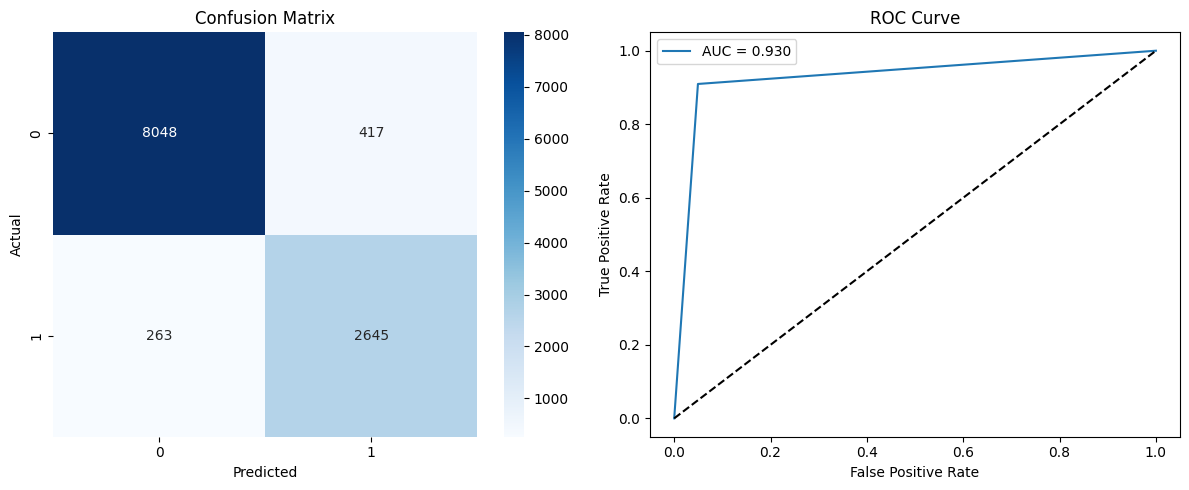

Random Over-Sampling:
Accuracy  : 0.9574  (maximize)
Precision : 0.9254  (maximize)
Recall    : 0.9947  (maximize)
F1 Score  : 0.9588  (maximize)

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      8494
           1       0.93      0.99      0.96      8461

    accuracy                           0.96     16955
   macro avg       0.96      0.96      0.96     16955
weighted avg       0.96      0.96      0.96     16955



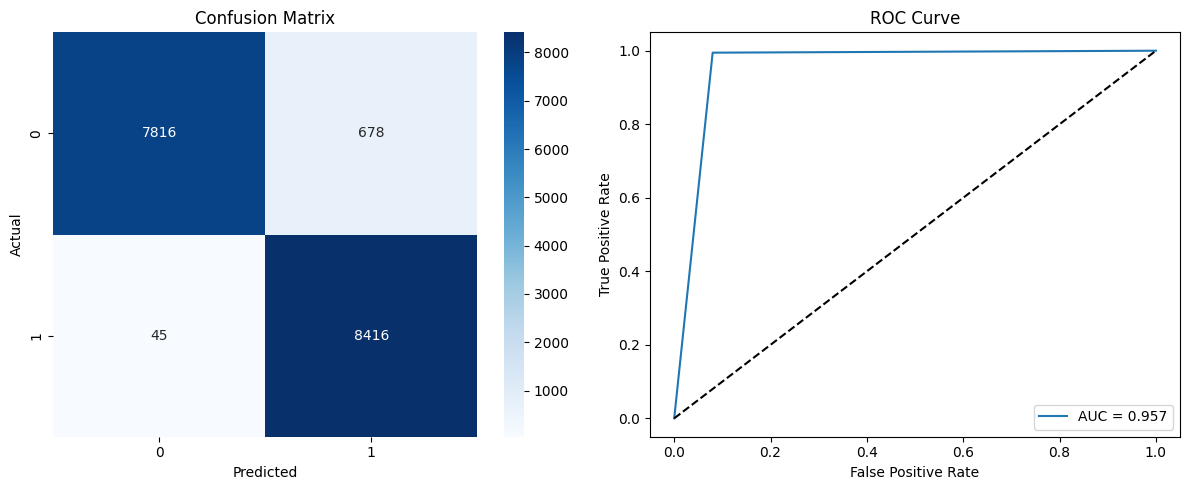

Random Under-Sampling:
Accuracy  : 0.9249  (maximize)
Precision : 0.8987  (maximize)
Recall    : 0.9588  (maximize)
F1 Score  : 0.9278  (maximize)

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2876
           1       0.90      0.96      0.93      2915

    accuracy                           0.92      5791
   macro avg       0.93      0.92      0.92      5791
weighted avg       0.93      0.92      0.92      5791



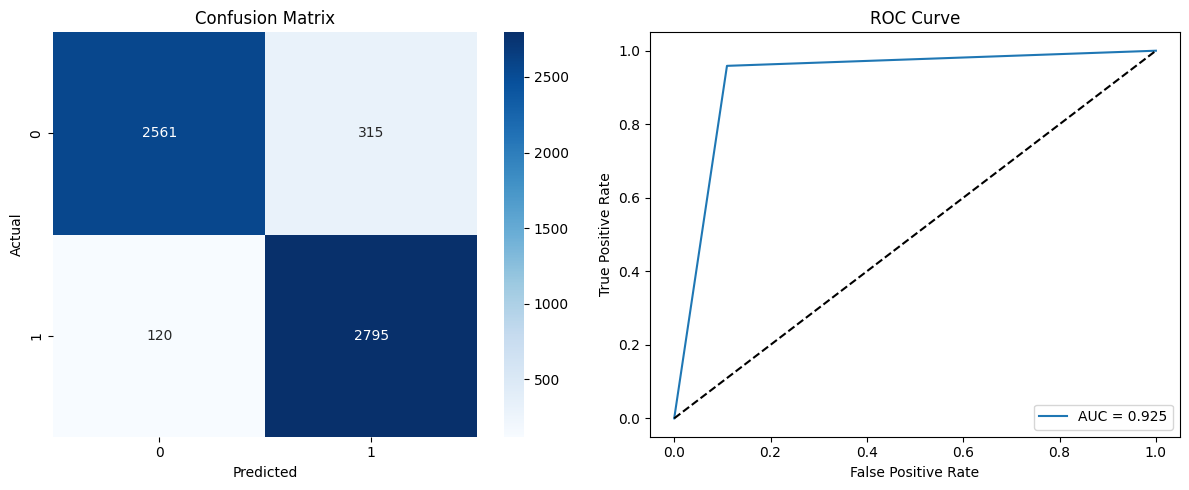

SMOTE Over-Sampling:
Accuracy  : 0.9516  (maximize)
Precision : 0.9272  (maximize)
Recall    : 0.9798  (maximize)
F1 Score  : 0.9527  (maximize)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      8509
           1       0.93      0.98      0.95      8446

    accuracy                           0.95     16955
   macro avg       0.95      0.95      0.95     16955
weighted avg       0.95      0.95      0.95     16955



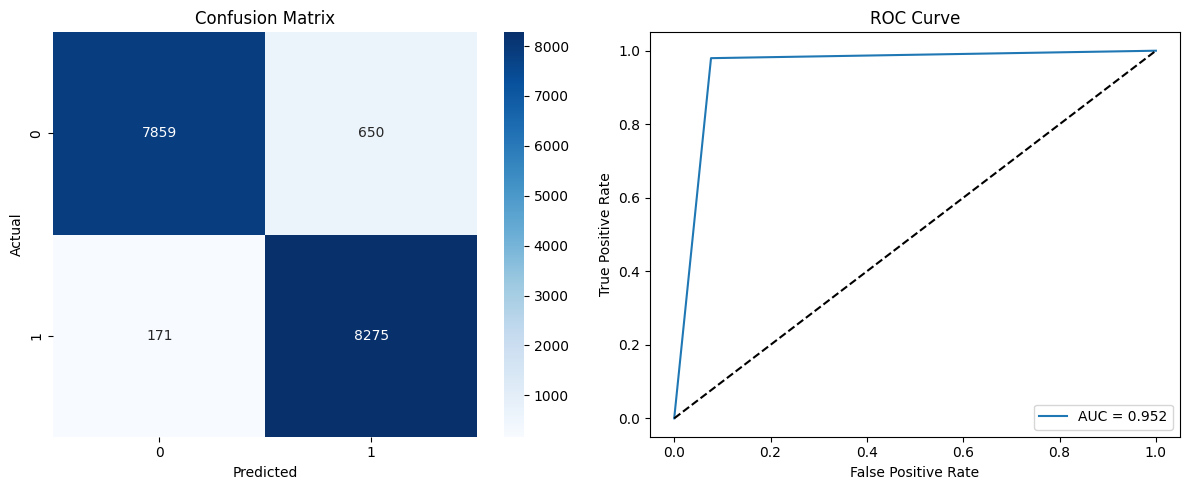

Tomek Links Under-Sampling:
Accuracy  : 0.9496  (maximize)
Precision : 0.8857  (maximize)
Recall    : 0.9254  (maximize)
F1 Score  : 0.9051  (maximize)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8322
           1       0.89      0.93      0.91      2922

    accuracy                           0.95     11244
   macro avg       0.93      0.94      0.94     11244
weighted avg       0.95      0.95      0.95     11244



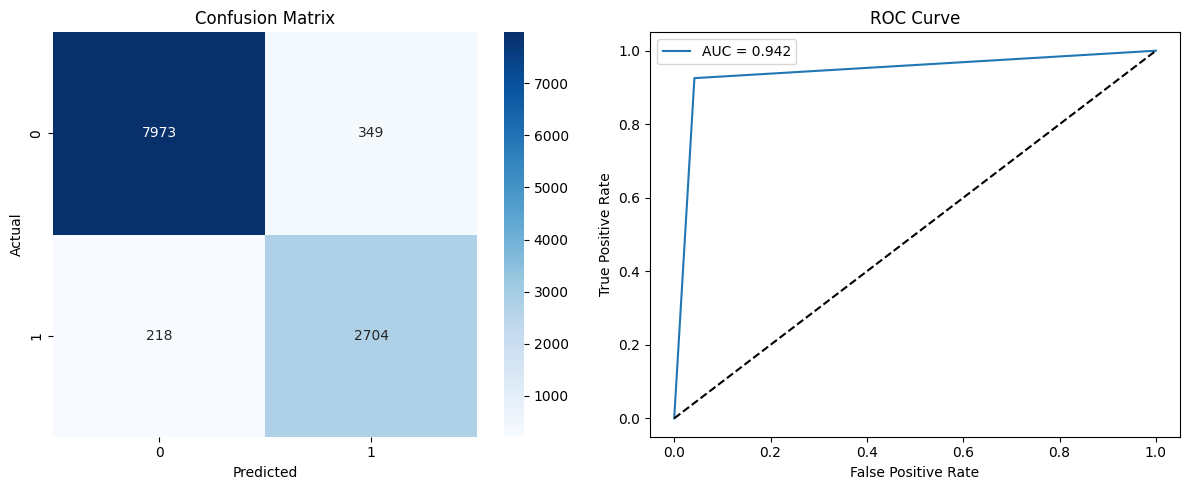

Best sampling method: Random Over-Sampling with ROC AUC: 0.9574
New dataset sizes: Train=67819, Test=16955, Full=84774
Class distribution: class 0: 33893, class 1: 33926


In [4]:
print("Original dataset:")
main(X_df, Y_df)
print("Random Over-Sampling:")
main(*random_over_sample(X_df, Y_df))
print("Random Under-Sampling:")
main(*random_under_sample(X_df, Y_df))
print("SMOTE Over-Sampling:")
main(*smote_over_sample(X_df, Y_df))
print("Tomek Links Under-Sampling:")
main(*tomek_under_sample(X_df, Y_df))

sampled_dataset.print_report("ROC AUC")
X_np_train = sampled_dataset.best_X_train
Y_np_train = sampled_dataset.best_y_train
X_np_test = sampled_dataset.best_X_test
Y_np_test = sampled_dataset.best_y_test

# Parameter Tuning

In [5]:

search_space = {
    "n_neighbors": Integer(1, 10),
    "weights": Categorical(["uniform", "distance"]),
}

model = KNeighborsClassifier()

bayes = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=20,           # number of evaluations
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42,
)

bayes.fit(X_np_train, Y_np_train)

best_model = bayes.best_estimator_
print(bayes.best_params_)


OrderedDict([('n_neighbors', 1), ('weights', 'distance')])
